In [1]:
import tensorflow as tf
import keras
import numpy as np

In [2]:
# Dataset link : https://www.kaggle.com/competitions/dogs-vs-cats/data

In [3]:
# We want to work on a smaller dataset, and try to achieve good results, so we will be taking the following number of images from the folder
# Training : 1000 samples of each class
# Validation : 1000 samples of each class
# Testing  : 1000 samples of each class

In [4]:
import os, shutil, pathlib

original_dir = pathlib.Path("dogs_vs_cats")
new_base_dir = pathlib.Path("dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    """
    Make a subset of the original dataset.
    """
    print(f"Creating subset {subset_name}")
    for category in ("cat","dog"):
        dir = new_base_dir / subset_name / category # Path for the new directory (subset_name will be train / test / validation)
        os.makedirs(dir) # Making the directory
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)] # Selecting the range of files for both the categories, and we need to provide starting and ending index as input
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname, dst = dir / fname) # Copying the file from original folder to destination folder(new folder created)
                            

In [5]:
# Running the above function to create a subset of the original dataset
make_subset(subset_name="train",start_index=0,end_index=1000)
make_subset(subset_name="validation",start_index=1000,end_index=1500)
make_subset(subset_name="test",start_index=1500,end_index=2500)

Creating subset train
Creating subset validation
Creating subset test


In [6]:
from keras.layers import Dense,Conv2D,Input,Rescaling,MaxPool2D,Flatten
from keras.models import Model

In [7]:
# Taking the input dimension as 180 , 180 , 3 - arbitary choice(mentioned in book)

In [8]:
input_layer = Input(shape=(180,180,3)) # RGB i.e colored photos , so channels = 3

rescaling_layer = Rescaling(1./255)(input_layer) # For Scaling the pixel values to 0 and 1
conv_layer1 = Conv2D(kernel_size=(3,3),filters=32,activation="relu")(rescaling_layer)  # kernel size = 3 and kernel size = 3,3 both are same
max_pool_layer1 = MaxPool2D(pool_size=2)(conv_layer1)

conv_layer2 = Conv2D(kernel_size=3,filters=64,activation="relu")(max_pool_layer1)
max_pool_layer2 = MaxPool2D(pool_size=2)(conv_layer2)

conv_layer3 = Conv2D(kernel_size=3,filters=128,activation="relu")(max_pool_layer2)
max_pool_layer3 = MaxPool2D(pool_size=2)(conv_layer3)

conv_layer4 = Conv2D(kernel_size=3,filters=256,activation="relu")(max_pool_layer3)
max_pool_layer4 = MaxPool2D(pool_size=2)(conv_layer4)

conv_layer5 = Conv2D(kernel_size=3,filters=256,activation="relu")(max_pool_layer4) # Kept as 256 , not 512 to reduce computational cost
flatten_layer = Flatten()(conv_layer5)

output_layer = Dense(1,activation="sigmoid")(flatten_layer)

model = Model(inputs = input_layer, outputs = output_layer)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [10]:
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics="accuracy")

In [11]:
# Data Preprocessing to convert our JPEG images to input tensors with appropriate dimensions compatible with our model
# The utils function will be expecting in the directory that we are giving, different folder with images , and each folder corresponds to a class (5 classes means 5 folders with any no. of images)
# The function will be creating a tensorflow dataset object to read the files, decode them into tensors, resize them and pack them into batches
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train", # Specifying the directory for our train folder
    image_size=(180,180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", # Specifying the directory for our validation folder
    image_size=(180,180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test", # Specifying the directory for our test folder
    image_size=(180,180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
for data_batch , label_batch in train_dataset:
    print(data_batch.shape)
    print(label_batch.shape)
    break # Break used to print only 1 batch shape

(32, 180, 180, 3)
(32,)


In [13]:
# The images are reshaped and batched

In [14]:
# Callback function for model checkpoint
from keras.callbacks import ModelCheckpoint

In [15]:
callbacks_list = [ModelCheckpoint(save_best_only=True,filepath="Cats_vs_Dogs_Best_Model.keras",monitor="val_loss")]

In [16]:
# No need to seperately mention images and labels, directly mentioning the training_dataset object and validation_dataset object is fine
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=30,callbacks=callbacks_list) 
history

Epoch 1/30
63/63 [==============================] - 9s 69ms/step - loss: 0.7132 - accuracy: 0.5230 - val_loss: 0.6883 - val_accuracy: 0.5270
Epoch 2/30
63/63 [==============================] - 4s 55ms/step - loss: 0.7260 - accuracy: 0.5815 - val_loss: 0.6355 - val_accuracy: 0.6450
Epoch 3/30
63/63 [==============================] - 3s 54ms/step - loss: 0.6842 - accuracy: 0.5990 - val_loss: 0.7024 - val_accuracy: 0.5690
Epoch 4/30
63/63 [==============================] - 3s 53ms/step - loss: 0.7172 - accuracy: 0.6520 - val_loss: 0.6304 - val_accuracy: 0.6390
Epoch 5/30
63/63 [==============================] - 3s 53ms/step - loss: 0.6145 - accuracy: 0.6790 - val_loss: 0.5981 - val_accuracy: 0.6730
Epoch 6/30
63/63 [==============================] - 3s 53ms/step - loss: 0.5632 - accuracy: 0.7190 - val_loss: 0.5741 - val_accuracy: 0.6970
Epoch 7/30
63/63 [==============================] - 3s 54ms/step - loss: 0.5379 - accuracy: 0.7250 - val_loss: 0.6131 - val_accuracy: 0.6980
Epoch 8/30
63

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

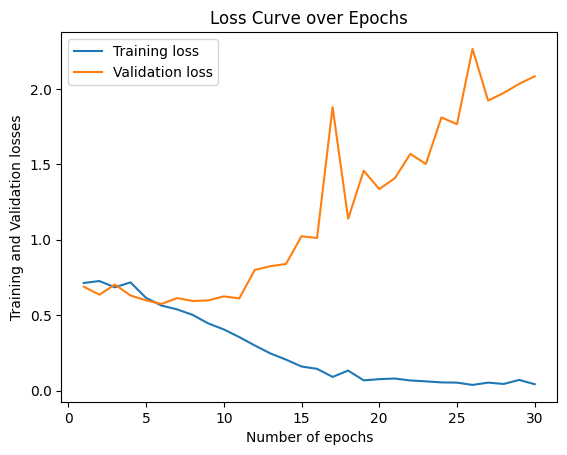

In [18]:
# Plotting the accuracy and loss curves

import matplotlib.pyplot as plt

num_epochs = range(1, len(history_dict["loss"])+1)

plt.plot(num_epochs, history_dict["loss"], label="Training loss")
plt.plot(num_epochs, history_dict["val_loss"], label="Validation loss")

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation losses")
plt.title("Loss Curve over Epochs")
plt.show()
                   

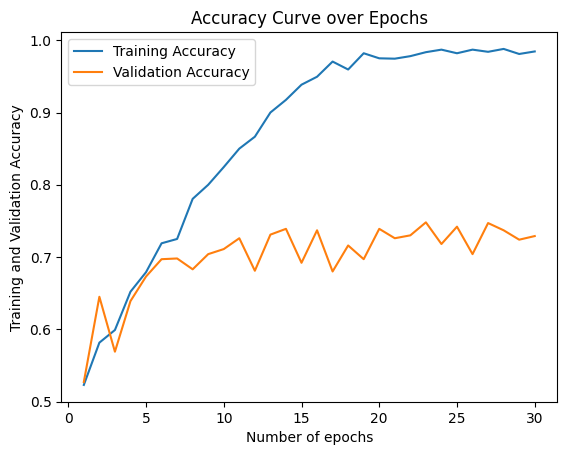

In [19]:
num_epochs = range(1, len(history_dict["loss"])+1)

plt.plot(num_epochs, history_dict["accuracy"], label="Training Accuracy")
plt.plot(num_epochs, history_dict["val_accuracy"], label="Validation Accuracy")

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation Accuracy")
plt.title("Accuracy Curve over Epochs")
plt.show()

In [20]:
# Both the curves show validation loss is increasing and validation accuracy is decreasing, that means our model is overfitting. So our model is capable of handling this image dataset
# And we dont need to retrain our model again until validation loss is minimum, since we used a model checkpoint, so our model is saved with the lowest validation loss

In [21]:
# We will not load the best model we got, and evaluate on test dataset

best_model = keras.models.load_model("Cats_vs_Dogs_Best_Model.keras")
test_loss,test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss : {test_loss}, Test Accuracy : {test_accuracy}")

63/63 [==============================] - 1s 18ms/step - loss: 0.5921 - accuracy: 0.6785
Test Loss : 0.5920958518981934, Test Accuracy : 0.6784999966621399


In [22]:
# Now due to less data , our model is prone to overfitting, so we will apply data augmentation

In [23]:
from keras import Sequential
from keras.layers import RandomFlip,RandomRotation,RandomZoom

In [24]:
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.2)
    ]
)

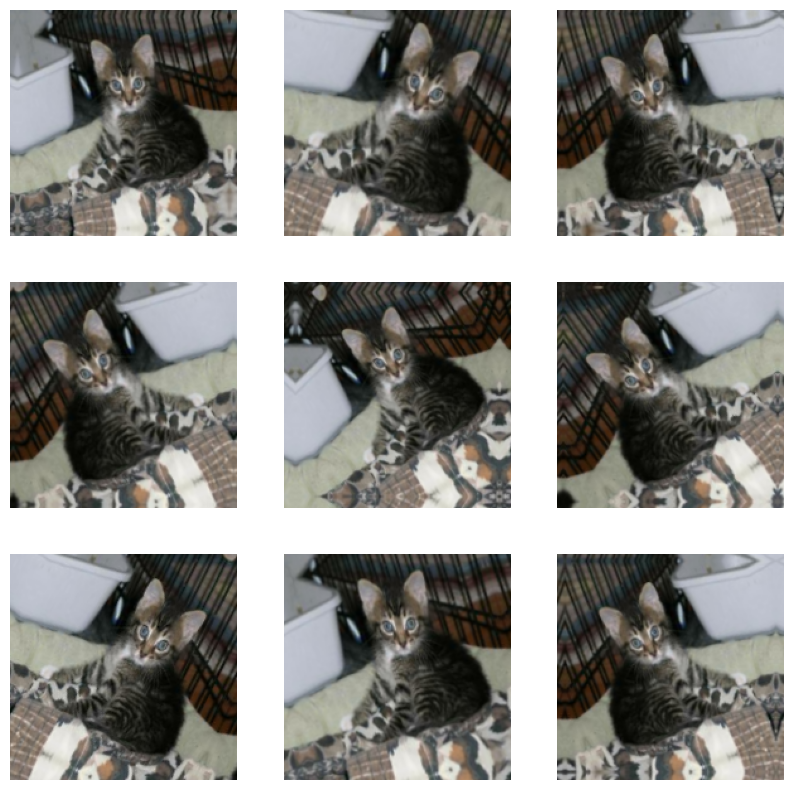

In [25]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1): # Taking only 1 batch of images
    for i in range(9):
        augmented_images = data_augmentation(images) # Data Augmentation
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # We are displaying only 9 augmentated images of the first image in train dataset batch
        plt.axis("off")

In [26]:
# We will be using the data_augmentation as a layer in our model at start for data augmentation
# We will add dropout as well, because we are modifying the existing images only , so there is some inter relation between the images, so overfitting is not much avoided
# So we add dropout as regularization, so that we can avoid overfitting as long as we can, and our model gets good results
# Just like dropout, data augmentation layer is inactive during inference.

In [27]:
from keras.layers import Dropout

In [28]:
input_layer = Input(shape=(180,180,3)) # RGB i.e colored photos , so channels = 3

data_augment_layer = data_augmentation(input_layer) # Data augmentation layer
rescaling_layer = Rescaling(1./255)(data_augment_layer) # For Scaling the pixel values to 0 and 1
conv_layer1 = Conv2D(kernel_size=(3,3),filters=32,activation="relu")(rescaling_layer)  # kernel size = 3 and kernel size = 3,3 both are same
max_pool_layer1 = MaxPool2D(pool_size=2)(conv_layer1)

conv_layer2 = Conv2D(kernel_size=3,filters=64,activation="relu")(max_pool_layer1)
max_pool_layer2 = MaxPool2D(pool_size=2)(conv_layer2)

conv_layer3 = Conv2D(kernel_size=3,filters=128,activation="relu")(max_pool_layer2)
max_pool_layer3 = MaxPool2D(pool_size=2)(conv_layer3)

conv_layer4 = Conv2D(kernel_size=3,filters=256,activation="relu")(max_pool_layer3)
max_pool_layer4 = MaxPool2D(pool_size=2)(conv_layer4)

conv_layer5 = Conv2D(kernel_size=3,filters=256,activation="relu")(max_pool_layer4) # Kept as 256 , not 512 to reduce computational cost
flatten_layer = Flatten()(conv_layer5)
dropout_layer = Dropout(0.5)(flatten_layer)

output_layer = Dense(1,activation="sigmoid")(dropout_layer)

model1 = Model(inputs = input_layer, outputs = output_layer)

In [29]:
model1.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics="accuracy")

In [30]:
callbacks_list1 = [ModelCheckpoint(save_best_only=True,filepath="Cats_vs_Dogs_Best_Model_data_augmentation.keras",monitor="val_loss")]

In [31]:
history1 = model1.fit(train_dataset,epochs=100,callbacks=callbacks_list1,validation_data=validation_dataset)
history1

Epoch 1/100
63/63 [==============================] - 21s 274ms/step - loss: 0.7564 - accuracy: 0.4990 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 31s 489ms/step - loss: 0.7068 - accuracy: 0.5060 - val_loss: 0.6915 - val_accuracy: 0.5020
Epoch 3/100
63/63 [==============================] - 36s 570ms/step - loss: 0.6934 - accuracy: 0.5315 - val_loss: 0.6836 - val_accuracy: 0.6050
Epoch 4/100
63/63 [==============================] - 33s 524ms/step - loss: 0.6831 - accuracy: 0.5845 - val_loss: 0.6703 - val_accuracy: 0.5760
Epoch 5/100
63/63 [==============================] - 33s 523ms/step - loss: 0.6644 - accuracy: 0.6175 - val_loss: 0.7315 - val_accuracy: 0.5740
Epoch 6/100
63/63 [==============================] - 33s 521ms/step - loss: 0.6517 - accuracy: 0.6460 - val_loss: 0.6328 - val_accuracy: 0.6530
Epoch 7/100
63/63 [==============================] - 33s 522ms/step - loss: 0.6209 - accuracy: 0.6660 - val_loss: 0.6495 - val_accuracy:

In [32]:
history_dict1 = history1.history
history_dict1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

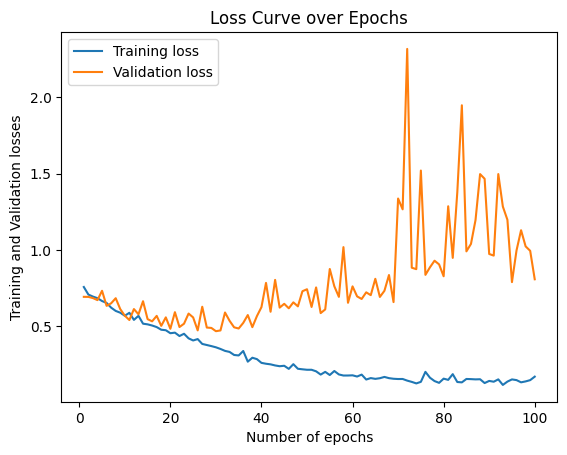

In [33]:
# Plotting the accuracy and loss curves

import matplotlib.pyplot as plt

num_epochs = range(1, len(history_dict1["loss"])+1)

plt.plot(num_epochs, history_dict1["loss"], label="Training loss")
plt.plot(num_epochs, history_dict1["val_loss"], label="Validation loss")

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation losses")
plt.title("Loss Curve over Epochs")
plt.show()

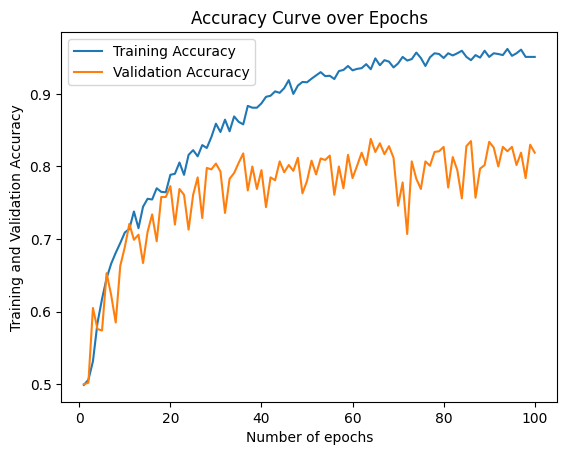

In [34]:
num_epochs = range(1, len(history_dict1["loss"])+1)

plt.plot(num_epochs, history_dict1["accuracy"], label="Training Accuracy")
plt.plot(num_epochs, history_dict1["val_accuracy"], label="Validation Accuracy")

plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Training and Validation Accuracy")
plt.title("Accuracy Curve over Epochs")
plt.show()